In [1]:
import numpy as np
import torch
from ADEN import ADEN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def d_t(x, y):
    return 0.5 * torch.sum((x - y)** 2) 

In [3]:
N = 100 # number of samples
M = 30 # number of clusters
Batch_size = 16 # number of batches
num_samples_in_batch = 8 # number of samples in each batch
input_dim = 2 # dimensionality of the input space
# X = torch.rand(N, input_dim).to(device)  # example input tensor (N, input_dim)
X = torch.tensor(np.loadtxt("D31.txt")[:,:2],device=device,dtype=torch.float32) / 31
N = X.shape[0]
Y = torch.rand(M, input_dim).to(device)  # example cluster tensor (M, input_dim)
model = ADEN(input_dim=input_dim, d_model=64, n_layers=3, d_ff=128).to(device)


In [4]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
Y_batches = Y.unsqueeze(0).expand(Batch_size, -1, -1).to(device)  # (Batch_size, M, input_dim)
for epoch in range(1000):  # example training loop

    X_batches = torch.zeros(Batch_size, num_samples_in_batch, input_dim).to(device)  # (Batch_size, num_samples_in_batch, input_dim)
    for i in range(Batch_size):
        batch_indices = torch.randint(0, N, (num_samples_in_batch,)).to(device)
        X_batches[i] = X[batch_indices]
    

    predicted_distances = model(X_batches, Y_batches) # predicted distances (Batch_size, num_samples_in_batch, M)
    idx = torch.argmin(predicted_distances, dim=-1).long()  # indices of the closest clusters (Batch_size, num_samples_in_batch)
    # create a mask of chosen indices to only include them in the training error
    mask = torch.zeros_like(predicted_distances, dtype=torch.bool)
    mask.scatter_(2, idx.unsqueeze(2), 1) # (Batch_size, num_samples_in_batch, M)
    gamma = 100.0
    transition_probs = torch.exp(-gamma *0.5*torch.cdist(Y,Y, p=2)**2)  # (M, M)
    transition_probs = transition_probs / transition_probs.sum(dim=-1, keepdim=True)
    D = torch.zeros(Batch_size, num_samples_in_batch, M).to(device)  # (Batch_size, num_samples_in_batch)
    for i in range(Batch_size):
        for j in range(num_samples_in_batch):
            realized_cluster = torch.multinomial(transition_probs[idx[i][j]], 1).item()
            D[i][j][idx[i][j]] = d_t(X_batches[i][j], Y[realized_cluster])
    # take MSE error between D and predicted_distances only when mask is true
    mse_loss = torch.mean((D[mask] - predicted_distances[mask]) ** 2)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, MSE Loss: {mse_loss.item()}")
    optimizer.zero_grad()
    mse_loss.backward()
    optimizer.step()

Epoch 0, MSE Loss: 0.4566698670387268
Epoch 100, MSE Loss: 0.005612246226519346
Epoch 200, MSE Loss: 0.004062331281602383
Epoch 300, MSE Loss: 0.004208059515804052
Epoch 400, MSE Loss: 0.003704786067828536
Epoch 500, MSE Loss: 0.003578492905944586
Epoch 600, MSE Loss: 0.0029446370899677277
Epoch 700, MSE Loss: 0.0026626463513821363
Epoch 800, MSE Loss: 0.004263055510818958
Epoch 900, MSE Loss: 0.0034491270780563354


In [5]:
y_to_be_optimized = Y.clone().detach().requires_grad_(True)  # make Y a parameter to be optimized
# fix model weights
for param in model.parameters():
    param.requires_grad = False
model.eval()

ADEN(
  (data_projection): Linear(in_features=2, out_features=64, bias=True)
  (cluster_projection): Linear(in_features=2, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x AdaptiveDistanceBlock(
      (attention): MultiHeadDistanceAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=False)
        (W_k): Linear(in_features=64, out_features=64, bias=False)
        (W_v): Linear(in_features=64, out_features=64, bias=False)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
 

In [8]:
optimizer_y = torch.optim.AdamW([y_to_be_optimized], lr=1e-4, weight_decay=1e-5)

beta = 50
F_old = torch.tensor(float('inf'), device=device)  # Initialize F_old to a large value
epoch = 0
while True:
    # Update y_to_be_optimized using the gradients
    d_s = model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0] # (N, M)
    F = -1/N/beta*torch.sum(torch.log(torch.sum(torch.exp(-beta*d_s), dim=-1)))
    optimizer_y.zero_grad()
    F.backward()
    optimizer_y.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, F: {F.item()}")
    if torch.norm(F_old - F)/torch.norm(F_old) < 1e-8:
        break
    F_old = F.clone()  # Update F_old for the next iteration
    epoch += 1

Epoch 0, F: 0.011777474544942379
Epoch 100, F: 0.011454140767455101
Epoch 200, F: 0.011152315884828568
Epoch 300, F: 0.010869801044464111
Epoch 400, F: 0.010604523122310638
Epoch 500, F: 0.010354837402701378
Epoch 600, F: 0.01011938601732254
Epoch 700, F: 0.009897100739181042
Epoch 800, F: 0.00968713779002428
Epoch 900, F: 0.009488793089985847
Epoch 1000, F: 0.009301429614424706
Epoch 1100, F: 0.009124455973505974
Epoch 1200, F: 0.00895735528320074
Epoch 1300, F: 0.008799614384770393
Epoch 1400, F: 0.00865078717470169
Epoch 1500, F: 0.00851043313741684
Epoch 1600, F: 0.008378144353628159
Epoch 1700, F: 0.008253534324467182
Epoch 1800, F: 0.008136255666613579
Epoch 1900, F: 0.008025942370295525
Epoch 2000, F: 0.007922259159386158
Epoch 2100, F: 0.00782488938421011
Epoch 2200, F: 0.007733522914350033
Epoch 2300, F: 0.007647850085049868
Epoch 2400, F: 0.007567576598376036
Epoch 2500, F: 0.007492430042475462
Epoch 2600, F: 0.007422128692269325
Epoch 2700, F: 0.00735641410574317
Epoch 2800,

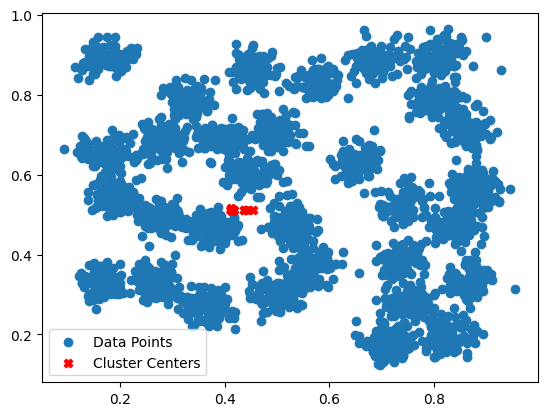

In [9]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = y_to_be_optimized.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()

In [6]:
model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0]

tensor([[0.1169, 0.1159, 0.1016,  ..., 0.1188, 0.1150, 0.0970],
        [0.1100, 0.1095, 0.0967,  ..., 0.1189, 0.1108, 0.0914],
        [0.1142, 0.1133, 0.0997,  ..., 0.1178, 0.1129, 0.0950],
        ...,
        [0.0899, 0.0875, 0.0838,  ..., 0.0844, 0.0804, 0.0902],
        [0.0884, 0.0861, 0.0819,  ..., 0.0828, 0.0793, 0.0875],
        [0.0828, 0.0809, 0.0777,  ..., 0.0820, 0.0757, 0.0826]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [7]:
0.5*torch.cdist(X, y_to_be_optimized, p=2)**2

tensor([[0.3276, 0.3156, 0.1857,  ..., 0.3166, 0.2944, 0.1514],
        [0.3045, 0.2968, 0.1752,  ..., 0.3582, 0.2960, 0.1310],
        [0.3172, 0.3061, 0.1791,  ..., 0.3215, 0.2892, 0.1434],
        ...,
        [0.1487, 0.1184, 0.0783,  ..., 0.0650, 0.0230, 0.1626],
        [0.1491, 0.1195, 0.0718,  ..., 0.0612, 0.0264, 0.1492],
        [0.1162, 0.0899, 0.0537,  ..., 0.0866, 0.0131, 0.1267]],
       device='cuda:0', grad_fn=<MulBackward0>)